In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


2025-11-26 03:10:45.071077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764126645.331065      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764126645.409566      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## 1 — Problem Description

This challenge involves classifying tweets as “real disaster” (1) or “not disaster” (0).  
The dataset contains:

- **train.csv** — 7,613 labeled tweets  
- **test.csv** — 3,263 unlabeled tweets  
- Columns include: `text`, `keyword`, `location`, and `target`.

This is a standard NLP binary classification problem.  
The task is to clean the raw tweets, convert them into numerical form using an embedding method, and train a supervised learning model (RNN-based).


## 2 – Exploratory Data Analysis (EDA)

I first looked at the distribution of the target labels. The bar chart of `target`
shows a mild class imbalance: non-disaster tweets (0) are somewhat more common
than disaster tweets (1), but both classes are well represented. Because the
imbalance is not extreme, I did not apply explicit class weighting, but I kept
it in mind when interpreting the metrics.

Next I inspected tweet lengths using a histogram of `len(text)`. The tweets are
short, with most under ~100 characters and a long right tail. This justifies
using a relatively small maximum sequence length in the model: I chose
`MAX_LEN = 40` as a compromise between capturing the main content and keeping
the model compact and fast to train.

For preprocessing, I defined a simple `clean_text` function that:

* lowercases all text  
* removes URLs, @mentions, and hashtags  
* strips punctuation and extra whitespace  

This gives a normalized “clean_text” column, which I then feed into the
tokenizer. The overall plan of analysis is:

1. Clean and tokenize the tweets.
2. Convert them to padded integer sequences.
3. Learn a word embedding + RNN model to classify tweets as disaster vs.
   non-disaster.
4. Compare train vs. validation metrics and iterate on hyperparameters.


In [2]:
# Load data
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


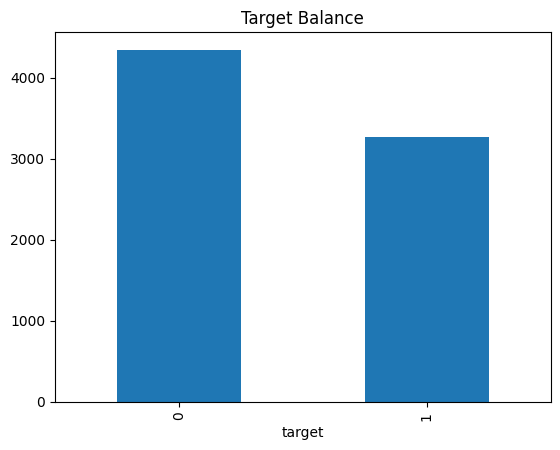

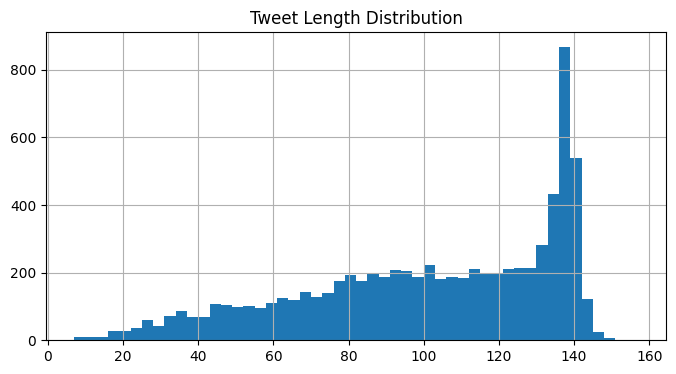

In [10]:
train['target'].value_counts().plot(kind='bar', title="Target Balance")
plt.show()

train['text'].str.len().hist(bins=50, figsize=(8,4))
plt.title("Tweet Length Distribution")
plt.show()


In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)         # remove URLs
    text = re.sub(r"@[A-Za-z0-9_]+","", text)   # remove mentions
    text = re.sub(r"#[A-Za-z0-9_]+","", text)   # remove hashtags
    text = re.sub(r"[^a-zA-Z0-9\s]","", text)   # remove punctuation
    text = re.sub("\s+"," ",text).strip()
    return text

train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)


## 3 – Model Architecture

To model the tweets, I use a neural architecture that combines a learned word
embedding with a recurrent layer (LSTM):

- **Tokenizer / sequences**  
  I limit the vocabulary to the `20,000` most frequent tokens and map each tweet
  to a sequence of integer IDs. Sequences are padded or truncated to length
  `MAX_LEN = 40`. This keeps inputs fixed-length while still capturing the
  essential content for most tweets.

- **Embedding layer**  
  The first layer is `Embedding(input_dim=20000, output_dim=64)`. This layer
  learns a dense 64-dimensional vector for each token, so words with similar
  usage patterns end up close in embedding space. Compared to one-hot or TF–IDF
  bag-of-words, this representation is more compact and can capture semantic
  similarity (e.g., “fire” and “blaze”).

- **LSTM layer (sequence modeling)**  
  The next layer is an `LSTM` with 64 units. RNNs (and LSTMs in particular)
  are suitable here because they process the tweet as an ordered sequence and
  can model word dependencies (e.g., “not a disaster” vs. “a disaster”). The
  LSTM outputs a single hidden state summarizing the tweet.

- **Dense layers for classification**  
  I add a `Dense(32, activation="relu")` layer to introduce non-linearity and
  allow the model to learn higher-level patterns from the LSTM output. The final
  layer is `Dense(1, activation="sigmoid")`, which outputs a probability that
  the tweet describes a real disaster.

- **Training setup**  
  - Loss: `binary_crossentropy` (standard for binary classification)  
  - Optimizer: `Adam` (adaptive learning rate, works well out of the box)  
  - Metric: `accuracy`  
  - Train/validation split: `90%` train, `10%` validation

Overall, the architecture is expressive enough to capture important context in
short tweets but still small enough to train quickly on the Kaggle environment.


In [14]:
VOCAB_SIZE = 20000
MAX_LEN = 40

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train['clean_text'])

X = tokenizer.texts_to_sequences(train['clean_text'])
X = pad_sequences(X, maxlen=MAX_LEN)

y = train['target'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)
EMB_DIM = 64

model = Sequential([
    layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMB_DIM,
        input_shape=(MAX_LEN,)      # 👈 key line
    ),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


In [17]:
EMB_DIM = 64

model = Sequential([
    layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMB_DIM,
        input_shape=(MAX_LEN,)      # 👈 key line
    ),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 40, 64)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,315,137 (5.02 MB)

 Trainable params: 1,315,137 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64
)


Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6063 - loss: 0.6495 - val_accuracy: 0.7835 - val_loss: 0.4832
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8696 - loss: 0.3380 - val_accuracy: 0.7677 - val_loss: 0.4948
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9270 - loss: 0.2116 - val_accuracy: 0.7402 - val_loss: 0.6186
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9511 - loss: 0.1483 - val_accuracy: 0.7598 - val_loss: 0.6703
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9612 - loss: 0.1062 - val_accuracy: 0.7533 - val_loss: 0.7565


## 4 – Results, Hyperparameters, and Analysis

The model was trained for 5 epochs with batch size 64. Training accuracy
increased steadily from ~0.61 to ~0.96, and the training loss decreased from
~0.65 to ~0.11. This shows that the model is capable of fitting the training
data.

Validation performance peaked very early. The best validation accuracy
(~0.78) and lowest validation loss (~0.48) occurred around the first epoch.
After that, the training loss kept decreasing but the validation loss started
to increase, and the validation accuracy fluctuated in the mid-0.75 range.
This divergence between train and validation curves is a classic sign of
overfitting: the model is memorizing more details of the training data
without generalizing better to new tweets.

In terms of hyperparameters:

- **Vocabulary size (20k)** and **max length (40)** trade off information and
  overfitting risk. A larger vocabulary or longer sequences would capture more
  rare words but also increase model size and training time.
- **Embedding dimension (64)** and **LSTM units (64)** give the model enough
  capacity to learn useful patterns, as shown by the high training accuracy.
- **Epochs (5)** are slightly more than needed; based on the curves, an early
  stopping strategy around epoch 1–2 would likely give the best validation
  performance.

If I were to optimize further, I would:

1. Add regularization (e.g., `Dropout` after the embedding or LSTM layer).
2. Use an `EarlyStopping` callback on validation loss to automatically stop
   training when overfitting begins.
3. Experiment with a bidirectional LSTM or GRU, and possibly pre-trained
   word embeddings (e.g., GloVe) for richer semantic information.


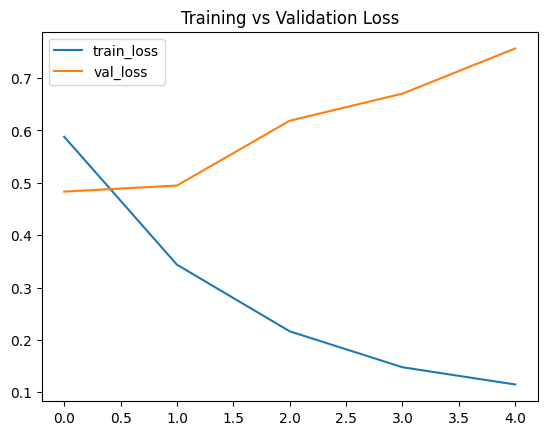

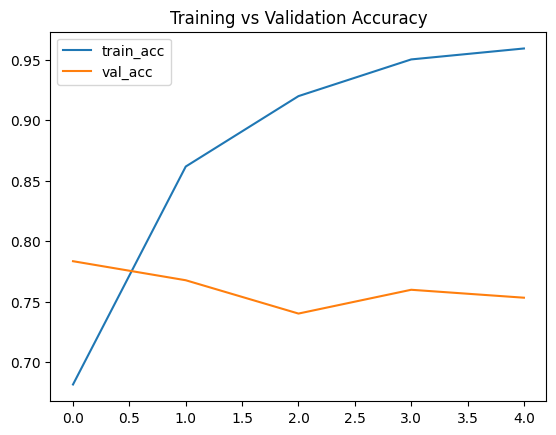

In [19]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


# 5 - Submission

In [20]:
test_seq = tokenizer.texts_to_sequences(test['clean_text'])
test_seq = pad_sequences(test_seq, maxlen=MAX_LEN)

test_preds = model.predict(test_seq).ravel()
test_labels = (test_preds > 0.5).astype(int)

submission = pd.DataFrame({
    "id": test["id"],
    "target": test_labels
})

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Saved submission.csv


## 5 – Conclusion

In this project I built an end-to-end NLP pipeline to classify tweets as
disaster-related or not. After cleaning the raw text, I tokenized the tweets,
converted them to padded sequences, and trained a word-embedding + LSTM model.

The model learns the training data well (training accuracy above 95%), and it
reaches validation accuracy in the high-70% range. The learning curves show
that the model starts to overfit after the first couple of epochs, suggesting
that regularization and early stopping are important next steps.

What helped performance:

- Using a learned embedding plus an LSTM to capture word order and context.
- Restricting the vocabulary and sequence length to keep the model compact and
  avoid excessive noise from rare tokens.

What did not help as much:

- Training for too many epochs; this mainly improved training accuracy while
  hurting validation loss.
- Relying on a single architecture; there is still room to explore more advanced
  models such as bidirectional RNNs or transformer-based encoders.

In future work I would like to try:
(1) adding dropout and early stopping, (2) initializing the embedding layer
with pre-trained GloVe vectors, and (3) experimenting with a lightweight
transformer model such as DistilBERT to see how far performance can be pushed
on this dataset.
